<a href="https://colab.research.google.com/github/ArnavKetkar/PortfolioProjects/blob/main/ImageCaptioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
import itertools

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [5]:
from keras import Input, layers
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector, Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras import optimizers
from keras.optimizers import Adam, RMSprop
from keras.applications.inception_v3 import preprocess_input, InceptionV3
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences, load_img, img_to_array
from keras.layers import add
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction, corpus_bleu
import cv2

In [6]:
project_path = '/content/drive/MyDrive/Image Captioning Project/'

In [7]:
#Loading doc to memory
def load_docu(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

doc = load_docu(project_path + 'Flickr8k.token.txt')
print(doc[:100])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .


In [8]:
def load_descriptions(doc):
    descriptions = {}
    for line in doc.split('\n'):
        if len(line)<2: 
            continue
        img_id, img_desc = line.split('\t')[0], line.split('\t')[1]
        img_id = img_id.split('#')[0]
        if img_id not in descriptions:
            descriptions[img_id] = []
        descriptions[img_id].append(img_desc)
    return descriptions


In [9]:
descriptions = load_descriptions(doc=doc)
print('Number of images = %d' % len(descriptions))

Number of images = 8092


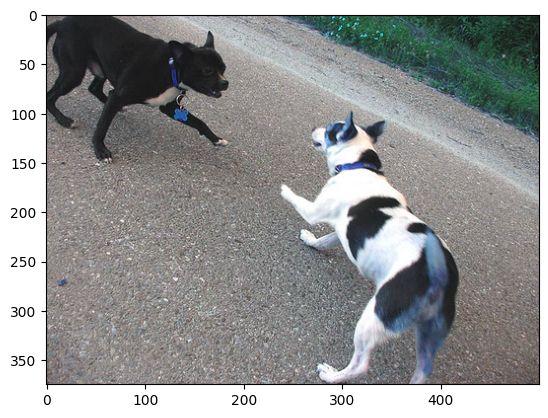

In [10]:
img = cv2.imread(project_path + 'Flicker8k_Dataset/' + '1001773457_577c3a7d70.jpg')
plt.imshow(img)

In [11]:
#Before Cleaining
descriptions['1001773457_577c3a7d70.jpg']

['A black dog and a spotted dog are fighting',
 'A black dog and a tri-colored dog playing with each other on the road .',
 'A black dog and a white dog with brown spots are staring at each other in the street .',
 'Two dogs of different breeds looking at each other on the road .',
 'Two dogs on pavement moving toward each other .']

In [12]:
def clean_descriptions(descriptions):
    table = str.maketrans('', '', string.punctuation)
    for id, descs in descriptions.items():
        for i in range(len(descs)): #using this form here helps in updating the desc in place
            desc = descs[i]
            desc = desc.split()
            #convert to lower case
            desc = [word.lower() for word in desc]
            #remove punctuation
            desc = [word.translate(table) for word in desc]
            #remove the a's
            desc = [word for word in desc if len(word)>1]
            descs[i] = ' '.join(desc)
clean_descriptions(descriptions)

In [13]:
#After Cleaning
descriptions['1001773457_577c3a7d70.jpg']

['black dog and spotted dog are fighting',
 'black dog and tricolored dog playing with each other on the road',
 'black dog and white dog with brown spots are staring at each other in the street',
 'two dogs of different breeds looking at each other on the road',
 'two dogs on pavement moving toward each other']

There are 8000 images each having 5 descriptions so we have total 8000*5 = 40000 captions

In [14]:
#Creating vocab of unique words in the 40000 captions
def create_vocablary(descriptions):
    vocab = set()
    for descs in descriptions.values():
        [vocab.update(desc.split()) for desc in descs]
    return vocab

vocabulary = create_vocablary(descriptions)
print('Original voabulary size: %d' % len(vocabulary))

Original voabulary size: 8808


In [15]:
#saving descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = []
    for id, descs in descriptions.items():
        for desc in descs:
            lines.append(id + ' ' + desc)
    data = ('\n').join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, project_path + 'descriptions.txt')

In [16]:
#Load the training set
def load_images_set(filename):
    images = []
    doc = load_docu(filename)
    for img_name in doc.split('\n'):
        if len(img_name)<1:
            continue
        sep = img_name.split('#')[0]
        images.append(sep)
    return set(images)


In [17]:
train = load_images_set(project_path + 'Flickr_8k.trainImages.txt')
print('There are %d training images' % len(train))

There are 6000 training images


In [18]:
test = load_images_set(project_path + 'Flickr_8k.testImages.txt')
print('There are %d testing images' % len(test))

There are 1000 testing images


In [19]:
#Adding SOS and EOS tokens to descriptions
def load_clean_descriptions(filename, dataset):
    doc = load_docu(filename)
    descriptions = {}
    for line in doc.split('\n'):
        if len(line)<2: 
            continue
        img_id, img_desc = line.split()[0], line.split()[1:]
        if img_id in dataset:
            if img_id not in descriptions:
                descriptions[img_id] = []
            desc = 'SOS ' + ' '.join(img_desc) + ' EOS'
            descriptions[img_id].append(desc)
    return descriptions
    

In [20]:
train_descriptions = load_clean_descriptions(project_path + 'descriptions.txt', train)

In [21]:
train_descriptions['1001773457_577c3a7d70.jpg']

['SOS black dog and spotted dog are fighting EOS',
 'SOS black dog and tricolored dog playing with each other on the road EOS',
 'SOS black dog and white dog with brown spots are staring at each other in the street EOS',
 'SOS two dogs of different breeds looking at each other on the road EOS',
 'SOS two dogs on pavement moving toward each other EOS']

In [22]:
test_descriptions = load_clean_descriptions(project_path + 'descriptions.txt', test)

In [23]:
test_descriptions['2654514044_a70a6e2c21.jpg']

['SOS brown dog running EOS',
 'SOS brown dog running over grass EOS',
 'SOS brown dog with its front paws off the ground on grassy surface near red and purple flowers EOS',
 'SOS dog runs across grassy lawn near some flowers EOS',
 'SOS yellow dog is playing in grassy area near flowers EOS']

In [24]:
#Create list of all training captions
all_train_caps = []
for key, val in train_descriptions.items():
    for caption in val:
        all_train_caps.append(caption)

len(all_train_caps)

30000

In [25]:
print(tf.config.list_physical_devices('GPU'))
print(len(tf.config.list_logical_devices("GPU")))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1


In [26]:
#load inception v3 model using imagenet
model = InceptionV3(weights='imagenet')

96112376/96112376 [==============================] - 3s 0us/step


In [27]:
# our purpose here is not to classify the image but just get fixed-length informative vector for each image. So, we just remove last softmax layer and extract 2048 length vector.
model_new = Model(model.input, model.layers[-2].output)
model_new.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [28]:
#Pre-processing Data
def preprocess_and_encode(img_path):
    #Inception net takes images of size 299x299 as input
    img = load_img(img_path, target_size = (299, 299))
    #Convert image to array
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    #use preprocess_input from inception module
    x = preprocess_input(x)
    #encode given image to vector of size (2048, )
    feature_vect = model_new.predict(x)
    feature_vect = np.squeeze(feature_vect)
    return feature_vect

In [29]:
'''
#Encode all training images
path = 'Flicker8k_Dataset/'
start = time()
encoding_train = {}
for img_id in train:
    img_path = path + img_id + '.jpg'
    encoding_train[img_id + '.jpg'] = preprocess_and_encode(img_path)
print("Time taken in seconds =", time()-start)
'''

'\n#Encode all training images\npath = \'Flicker8k_Dataset/\'\nstart = time()\nencoding_train = {}\nfor img_id in train:\n    img_path = path + img_id + \'.jpg\'\n    encoding_train[img_id + \'.jpg\'] = preprocess_and_encode(img_path)\nprint("Time taken in seconds =", time()-start)\n'

In [30]:
'''with open("train_encoded_images.p", "wb") as pickle_f:
    dump(encoding_train, pickle_f)'''

'with open("train_encoded_images.p", "wb") as pickle_f:\n    dump(encoding_train, pickle_f)'

In [31]:
encoded_train_pics = load(open(project_path + 'train_encoded_images.p', 'rb'))
print(len(encoded_train_pics))

6000


In [32]:
'''
path = 'Flicker8k_Dataset/'
start = time()
encoding_test = {}
for img_id in test:
    img_path = path + img_id + '.jpg'
    encoding_test[img_id + '.jpg'] = preprocess_and_encode(img_path)
print("Time taken in seconds =", time()-start)
'''

'\npath = \'Flicker8k_Dataset/\'\nstart = time()\nencoding_test = {}\nfor img_id in test:\n    img_path = path + img_id + \'.jpg\'\n    encoding_test[img_id + \'.jpg\'] = preprocess_and_encode(img_path)\nprint("Time taken in seconds =", time()-start)\n'

In [33]:
'''with open( "test_encoded_images.p", "wb" ) as pickle_f:
    dump(encoding_test, pickle_f )'''

'with open( "test_encoded_images.p", "wb" ) as pickle_f:\n    dump(encoding_test, pickle_f )'

In [34]:
encoded_test_pics = load(open(project_path + 'test_encoded_images.p', 'rb'))
print(len(encoded_test_pics))

1000


In [35]:
test_descriptions.keys() == encoded_test_pics.keys()

True

In [36]:
#Word-Index dictionaries
ixtoword = {}
wordtoix = {}

ix = 1
for word in vocabulary:
    wordtoix[word] = ix
    ixtoword[ix] = word
    ix += 1


In [37]:
ixtoword[0] = "Unk"
wordtoix["Unk"] = 0

ixtoword[8809] = "SOS"
wordtoix["SOS"] = 8809

ixtoword[8810] = "EOS"
wordtoix["EOS"] = 8810

In [38]:
vocab_size = len(ixtoword) #for eos and sos
vocab_size

8811

In [39]:
#Converting dictionary of clean descriptions to list of descriptions
def to_lines(descriptions):
    all_descs = []
    for key in descriptions.keys():
        [all_descs.append(d) for d in descriptions[key]]
    return all_descs

In [40]:
#Calculate max length of descriptions
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(line.split()) for line in lines)

#Find max length of training descriptions
max_length = max_length(train_descriptions)
print('Max training description length is ', max_length)

Max training description length is  34


In [41]:
encoded_training_captions = {}
for img_id in train_descriptions.keys():
    encoded_training_captions[img_id] = []
    for i in range(5):
        encoded_training_captions[img_id].append([wordtoix[w] for w in train_descriptions[img_id][i].split(" ")])

In [42]:
for img_id in encoded_training_captions.keys():
    encoded_training_captions[img_id] = pad_sequences(encoded_training_captions[img_id], max_length)

In [43]:
#Word embeddings using Glove
embedding_index = {}
f = open(project_path + 'glove.6B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split(' ')
    word = values[0]
    embeddings = np.asarray(values[1:], 'float32')
    embedding_index[word] = embeddings
f.close()

print("Found %d word vectors" % len(embedding_index))

Found 400000 word vectors


In [44]:
#Creating embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, ix in wordtoix.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[ix] = embedding_vector

In [45]:
embedding_matrix.shape

(8811, 200)

In [46]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
dropout1 = Dropout(0.3)(inputs1)
dense1 = Dense(256, activation='relu')(dropout1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
embedding1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
dropout2 = Dropout(0.3)(embedding1)
lstm1 = LSTM(256)(dropout2)

# decoder (feed forward) model
decoder1 = add([dense1, lstm1])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [47]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      1762200     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [48]:
#Setting weights to embedding layer using embedding matrix
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [49]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 34, 200)      1762200     ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [50]:
opt = tf.keras.optimizers.Adam(learning_rate = 0.005)

In [51]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [52]:
#Data Generator
def data_generator(encoded_training_captions, encoded_train_pics, max_length, vocab_size, num_pics_per_batch):
    X1, X2, y = [], [], []
    n = 0 

    while True:
        for id in encoded_training_captions.keys():
            n+=1
            pic = encoded_train_pics[id]
            for i in range(5):
                for j in range(1,max_length):
                    #Splitting each caption into X, y pairs
                    in_seq = encoded_training_captions[id][i][0:j].tolist()
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = encoded_training_captions[id][i][j]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(pic)
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == num_pics_per_batch:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [[X1, X2], y]
                X1, X2, y = list(), list(), list()
                n = 0 

In [53]:
epochs = 10
num_pics_per_batch = 32
steps = len(train_descriptions)//num_pics_per_batch

In [54]:
with tf.device('/GPU:0'):
    generator = data_generator(encoded_training_captions, encoded_train_pics, max_length, vocab_size, num_pics_per_batch)
    history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/10
187/187 [==============================] - 139s 689ms/step - loss: 1.9970 - accuracy: 0.6894
Epoch 2/10
187/187 [==============================] - 127s 680ms/step - loss: 1.5059 - accuracy: 0.7284
Epoch 3/10
187/187 [==============================] - 127s 677ms/step - loss: 1.3869 - accuracy: 0.7378
Epoch 4/10
187/187 [==============================] - 126s 673ms/step - loss: 1.3191 - accuracy: 0.7430
Epoch 5/10
187/187 [==============================] - 125s 670ms/step - loss: 1.2740 - accuracy: 0.7463
Epoch 6/10
187/187 [==============================] - 124s 663ms/step - loss: 1.2437 - accuracy: 0.7480
Epoch 7/10
187/187 [==============================] - 124s 661ms/step - loss: 1.2180 - accuracy: 0.7503
Epoch 8/10
187/187 [==============================] - 126s 674ms/step - loss: 1.1939 - accuracy: 0.7518
Epoch 9/10
187/187 [==============================] - 123s 661ms/step - loss: 1.1829 - accuracy: 0.7523
Epoch 10/10
187/187 [==============================] - 125s 669m

In [55]:
model.save(project_path + 'model.h5')

In [56]:
#Algorithm to choose word with highest probability
def greedySearch(pic):
    pic = pic.reshape(1, 2048)
    in_text = "SOS"
    for i in range(max_length):
        seq = [wordtoix[w] for w in in_text.split(" ") if w in wordtoix]
        seq = pad_sequences([seq], max_length)
        y_pred = model.predict([pic, seq], verbose=0)
        y_pred = np.argmax(y_pred[0])
        next_word = ixtoword[y_pred]
        in_text += ' ' + next_word
        if next_word == "EOS":
            break
    final = in_text.split()
    final = final[1:-1] #To remove EOS and SOS
    final = ' '.join(final)
    return final

In [57]:
test_descriptions['888425986_e4b6c12324.jpg']

['SOS boy is upside down in midair near lake at sunset EOS',
 'SOS person does flip by two sailboats and lake EOS',
 'SOS person flipping upside down EOS',
 'SOS person in midair doing back flip EOS',
 'SOS person is doing flip in midair near lake with sails behind him EOS']

In [58]:
list = []
for i in range(5):
  x = test_descriptions['888425986_e4b6c12324.jpg'][i].split(" ")
  x = x[1:-1]
  x = ' '.join(x)
  list.append(x)

list

['boy is upside down in midair near lake at sunset',
 'person does flip by two sailboats and lake',
 'person flipping upside down',
 'person in midair doing back flip',
 'person is doing flip in midair near lake with sails behind him']

In [59]:
len(encoded_test_pics['888425986_e4b6c12324.jpg'])

2048

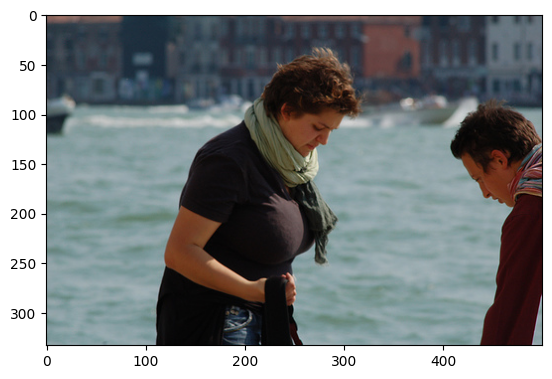

Reference Captions: 
man and woman at the waterfront
woman and man is standing beside water in front of buildings
woman holding black leash and man looking down
woman wearing scarf looks down
woman wearing scarf stands near the water and looks down
Predicted Caption: 
group of people are standing in front of the ocean
bleu score:  0.5620969882544705


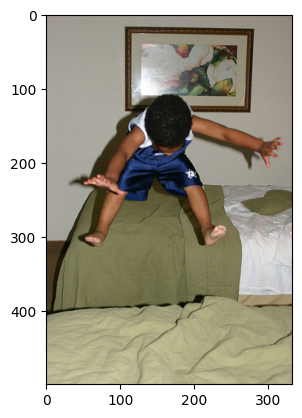

Reference Captions: 
boy is jumping on bed
boy jumped up from the green bed
boy jumps from one bed to another
small child is jumping on bed
the boy in blue shorts is bouncing on the bed
Predicted Caption: 
young boy in pink shirt is jumping into pool
bleu score:  0.5139613632830374


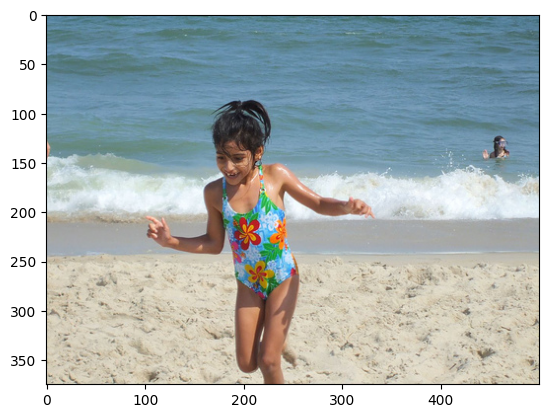

Reference Captions: 
girl smiles as she runs across the white sandy beach in her swimsuit
little girl in flowered bathingsuit runs through the sand at the beach
little girl in flower swimsuit running across the beach with waves in the background
there is little girl running on the beach
the young girl is running on sandy beach
Predicted Caption: 
little girl in red trunks is jumping into pool
bleu score:  0.5693406973484106


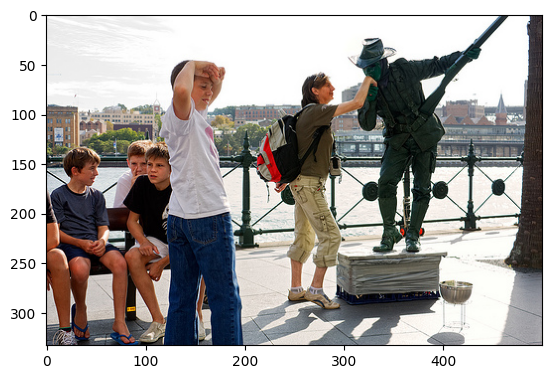

Reference Captions: 
group of tourists stand around as lady puts her hand near the mouth of statue
woman is making statue pretend to kiss her hand beside four boys at bench
woman posing with statue alongside group of boys
woman with backpack leans again statue while group of boys sit on bench talking
woman gets her hand kissed by living statue street artist
Predicted Caption: 
woman in red shirt is walking along the street
bleu score:  0.6579062195718075


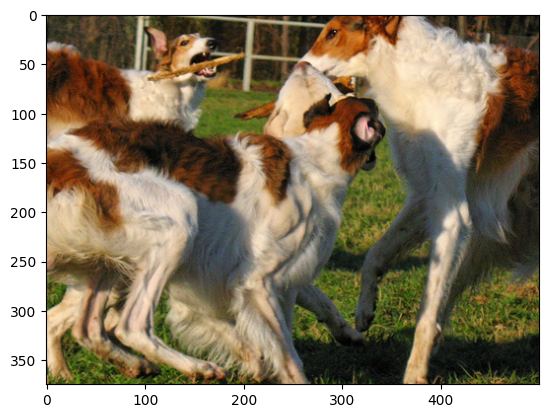

Reference Captions: 
group of large white and orange dogs are in the grass
dogs play with stick
four dogs play together outside with sticks
four dogs play with each other and with sticks
the dogs are playing with stick outside
Predicted Caption: 
two dogs are running on the grass
bleu score:  0.5760212426372139


In [60]:
#Predicting captions on test set using Greedy Search
i=0
for img_id in encoded_test_pics.keys():
  i+=1
  img = cv2.imread(project_path+'Flicker8k_Dataset/'+img_id)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  pic = encoded_test_pics[img_id]
  plt.show()
  references = []
  for caption in test_descriptions[img_id]:
    caps_list = caption.split(" ")
    caps_list = caps_list[1:-1] #To remove SOS and EOS
    caps_list = ' '.join(caps_list)
    references.append(caps_list)
  candidate = greedySearch(pic)
  smoothing_func = SmoothingFunction()
  score = sentence_bleu(references, candidate, smoothing_function=smoothing_func.method1)
  print("Reference Captions: ")
  for cap in references:
    print(cap)
  print("Predicted Caption: ")
  print(candidate)
  print("bleu score: ", score)
  if i==5:
    break
  

In [61]:
#Predicting average bleu score on test set using Greedy Search
with tf.device('/GPU:0'):
  i=0
  candidates = []
  references = []
  for img_id in encoded_test_pics.keys():
    i+=1
    pic = encoded_test_pics[img_id]
    reference = []
    for captions in test_descriptions[img_id]:
      caps_list = captions.split(" ")
      caps_list = caps_list[1:-1] #To remove SOS and EOS
      caps_list = ' '.join(caps_list)
      reference.append(caps_list)
    references.append(reference)
    candidates.append(greedySearch(pic))

smoothing_func = SmoothingFunction()

bleu = corpus_bleu(references, candidates, smoothing_function=smoothing_func.method1)
print("Average BLEU Score: ", bleu)

Average BLEU Score:  0.45063597751436435
